```
         Copyright Rein Halbersma 2020.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Monte Carlo simulation of multi-armed bandits

In [1]:
import gym
import numpy as np
import pandas as pd
import plotnine as p9

from doctrina.algorithms import mc

In [2]:
runs = 2_000
episodes = 1_000
bandits = np.array([
    gym.make('Bandit-v0', k=10) 
    for _ in range(runs)
])

In [3]:
qs = np.vstack([env.q_star for env in bandits])
qs.mean(axis=0)

array([ 1.52311951,  0.98954218,  0.64265272,  0.37306022,  0.12457288,
       -0.11498365, -0.36974536, -0.66256826, -1.0099012 , -1.54434141])

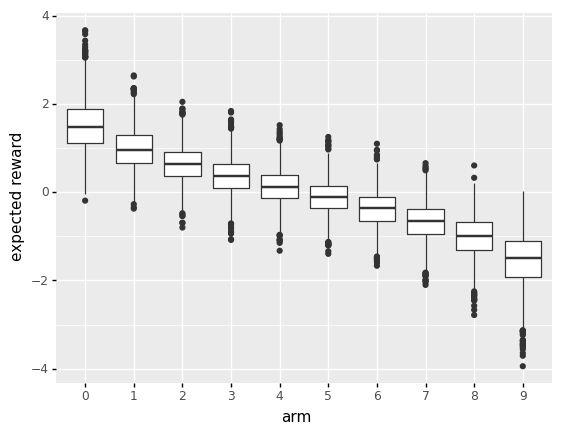

<ggplot: (8778621616520)>

In [4]:
df = (pd
    .DataFrame(qs)
    .rename_axis('env')
    .reset_index()
    .melt(id_vars='env', var_name='arm', value_name='expected reward')
)
p9.ggplot(df, p9.aes(y='expected reward', x='arm')) + p9.geom_boxplot()

In [5]:
dqs = qs - qs[:, 0].reshape(-1, 1)
dqs.mean(axis=0)

array([ 0.        , -0.53357733, -0.88046679, -1.15005929, -1.39854662,
       -1.63810316, -1.89286486, -2.18568777, -2.53302071, -3.06746092])

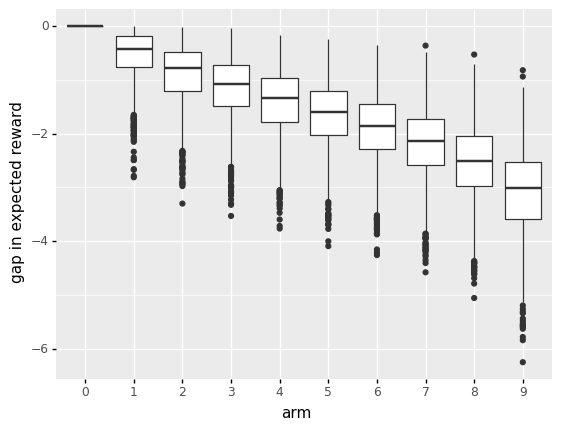

<ggplot: (8778619330320)>

In [6]:
df = (pd
    .DataFrame(dqs)
    .rename_axis('env')
    .reset_index()
    .melt(id_vars='env', var_name='arm', value_name='gap in expected reward')
)
p9.ggplot(df, p9.aes(y='gap in expected reward', x='arm')) + p9.geom_boxplot()

In [7]:
def action_history(a, id): 
    return (pd
        .DataFrame(a)
        .apply(lambda x: x.value_counts(normalize=True))
        .fillna(0)
        .T
        .rename_axis('Steps')
        .reset_index()
        .melt(id_vars='Steps', var_name='arm', value_name='selected')
        .assign(id = id)
    )

In [8]:
def reward_history(R, id):
    return (pd
        .DataFrame(R.mean(axis=0), columns=['reward'])
        .rename_axis('Steps')
        .reset_index()
        .assign(
            regret = lambda r: qs.mean(axis=0)[0] - r.reward,
            cumregret = lambda r: r.regret.cumsum(),
            id = id
        )
    )

In [9]:
def action_reward_history(a, R, id):
    return action_history(a, id), reward_history(R, id)

In [10]:
e = chr(949)
epsilons = [ 0, .01, .1 ]
labels = [ e+'=0 (greedy)', e+'=0.01', e+'=0.1' ]
df_a, df_R = tuple(pd
    .concat(list(t), sort=False)
    .drop_duplicates()
    .reset_index(drop=True)
    # The loop over mc.Q_policy_iter_bandit_eps returns a list of pairs of DataFrames.
    # The zip(*) operation transposes this into a pair of lists of DataFrames.
    for t in zip(*[
        action_reward_history(*mc.Q_policy_iter_bandit_eps(bandits, episodes, epsilon=epsilon), labels[i])
        for i, epsilon in enumerate(epsilons)
    ])
)

100%|██████████| 2000/2000 [02:38<00:00, 12.63it/s]


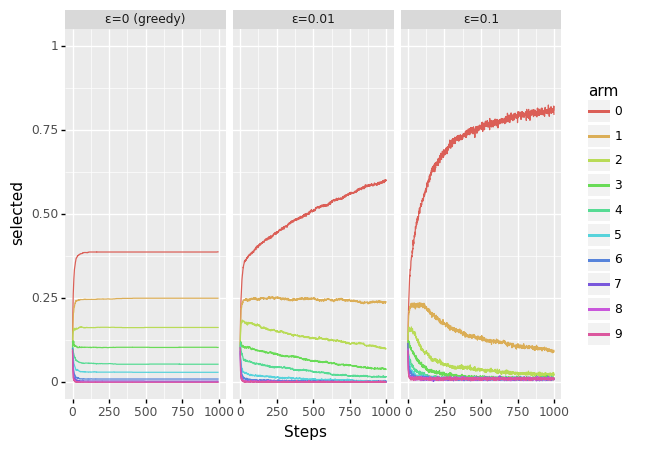

<ggplot: (8778615627870)>

In [11]:
p9.ggplot(df_a, p9.aes(y='selected', x='Steps')) + p9.ylim(0, 1) + p9.geom_line(p9.aes(color='arm')) + p9.facet_grid('. ~ id')

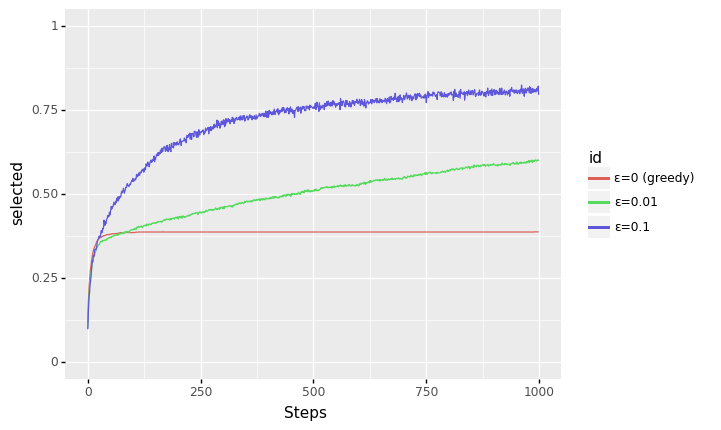

<ggplot: (8778621646484)>

In [13]:
p9.ggplot(df_a.query('arm == 0'), p9.aes(y='selected', x='Steps')) + p9.ylim(0, 1) + p9.geom_line(p9.aes(color='id'))

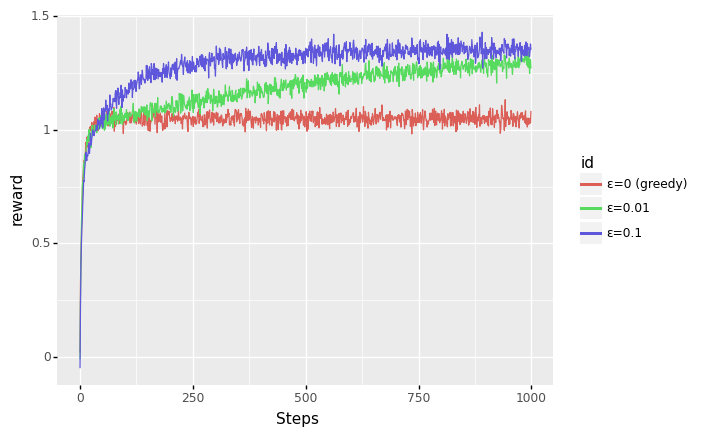

<ggplot: (8778615565611)>

In [14]:
p9.ggplot(df_R, p9.aes(y='reward', x='Steps')) + p9.geom_line(p9.aes(color='id'))

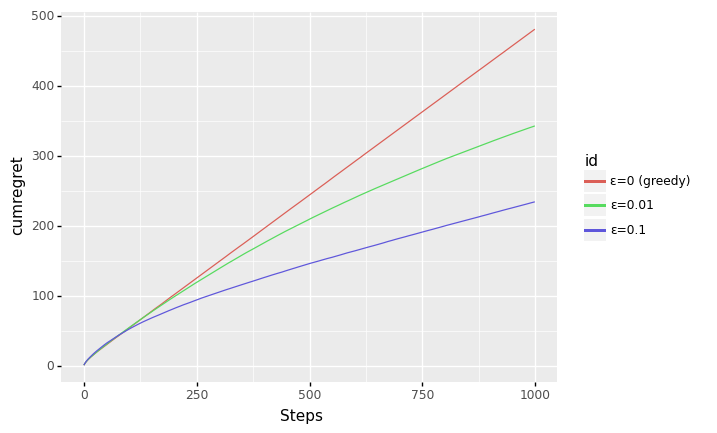

<ggplot: (8778615605941)>

In [15]:
p9.ggplot(df_R, p9.aes(y='cumregret', x='Steps')) + p9.geom_line(p9.aes(color='id'))